# This Notebook Illustrates Challenges Related to the Timeseries Index & Regressor Models

In [1]:
import pandas as pd

from dotenv import load_dotenv
import os
load_dotenv()

from fredapi import Fred

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import catboost as cb
from catboost import CatBoost

import numpy as np


In [2]:
# env variable
api_key = os.getenv("FRED_API_KEY")
fred = Fred(api_key=api_key)

In [3]:
# FRED timeseries API map dictionary
fred_timeseries_mapping = {
    'CPIAUCSL': 'Consumer Price Index for All Urban Consumers: All Items in U.S. City Average',
    'HOUST': 'New Privately-Owned Housing Units Started: Total Units',
    'CSUSHPINSA': 'S&P CoreLogic Case-Shiller U.S. National Home Price Index',
    'HPIPONM226S': 'Purchase Only House Price Index for the United States',
    'ETOTALUSQ176N': 'Housing Inventory Estimate: Total Housing Units in the United States',
    'USSTHPI': 'All-Transactions House Price Index for the United States',
    'WPUSI012011': 'Producer Price Index by Commodity: Special Indexes: Construction Materials',
    'ILSTHPI': 'All-Transactions House Price Index for Illinois',
    'MORTGAGE30US': '30-Year Fixed Rate Mortgage Average in the United States',
    'MORTGAGE15US': '15-Year Fixed Rate Mortgage Average in the United States',
    'MSACSR': 'Monthly Supply of New Houses in the United States',
    'MSPUS': 'Median Sales Price of Houses Sold for the United States'
}

start = "2000-01-01"
#end

dfs = []

for s in list(fred_timeseries_mapping.keys()):
    
    data = fred.get_series(s, observation_start=start)
    df = pd.DataFrame(data)

    df_grouped = df.groupby(by=[df.index.year, df.index.quarter]).mean()
    # display(df.isnull().any())
    dfs.append(df_grouped)
    
housing_data_df = pd.concat(dfs, axis=1)
housing_data_df.columns = list(fred_timeseries_mapping.keys())
housing_data_df.dropna(inplace=True)

display(housing_data_df.head(10))
display(housing_data_df.tail(10))

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2000 2  171.433333  1586.666667  103.699000   139.566667       116047.0   
     3  173.000000  1503.666667  106.459333   141.780000       116482.0   
     4  174.233333  1544.000000  108.270000   144.200000       116914.0   
2001 1  175.900000  1605.000000  109.750000   146.910000       117347.0   
     2  177.133333  1630.000000  112.241000   149.316667       117786.0   
     3  177.633333  1599.666667  114.893000   151.590000       118216.0   
     4  177.500000  1570.000000  115.858667   153.943333       118635.0   
2002 1  178.066667  1723.000000  117.094000   156.560000       119061.0   
     2  179.466667  1691.000000  120.776333   159.420000       119483.0   
     3  180.433333  1697.333333  124.636667   162.483333       119909.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  \
2000 2   233.89   145.166667   245.58      8.316154      7.991538  4.533333   
     3   238.16   143.833333   249.63      8.020000      7.733077  4.166667   
     4   241.80   142.833333   252.46      7.620769      7.294615  3.933333   
2001 1   247.79   142.266667   255.77      7.006923      6.589231  3.766667   
     2   251.94   143.666667   260.21      7.130000      6.660000  4.033333   
     3   255.85   143.233333   265.05      6.963846      6.506923  4.333333   
     4   259.02   142.033333   267.50      6.770769      6.253077  4.066667   
2002 1   262.73   142.466667   272.12      6.971538      6.461538  4.100000   
     2   267.21   143.866667   276.94      6.813077      6.286154  4.166667   
     3   272.51   145.066667   280.51      6.289231      5.712308  4.033333   

           MSPUS  
2000 2  163200.0  
     3  168800.0  
     4  172900.0  
2001 1  169800.0  
     2  179000.0  
     3  172500.0  
     4  171100.0  
2002 1  188700.0  
     2  187200.0  
     3  178100.0

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2021 2  268.622667  1581.666667  255.498000   333.000000       141927.0   
     3  272.890000  1576.333333  268.593000   348.133333       142288.0   
     4  278.680333  1690.333333  276.106667   361.763333       142697.0   
2022 1  284.826000  1717.666667  288.086000   377.643333       143105.0   
     2  291.706333  1635.666667  305.479000   390.660000       143514.0   
     3  295.509000  1446.333333  303.747333   390.126667       143923.0   
     4  298.441000  1405.333333  296.664000   391.553333       144332.0   
2023 1  301.203000  1385.333333  294.520000   394.996667       144740.0   
     2  303.466667  1449.666667  305.039667   403.173333       145149.0   
     3  306.034333  1370.666667  311.367333   412.006667       145558.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  \
2021 2   510.74   304.466667   385.96      3.003846      2.309231  5.366667   
     3   539.20   314.587000   399.44      2.872143      2.171429  6.066667   
     4   557.79   328.697333   408.73      3.079231      2.338462  6.133333   
2022 1   578.36   345.059000   419.56      3.822308      3.044615  6.333333   
     2   617.03   348.867000   445.57      5.266154      4.450769  8.766667   
     3   627.42   342.002333   450.94      5.623077      4.880769  9.500000   
     4   622.78   330.204667   446.16      6.664615      5.959231  9.200000   
2023 1   625.78   329.866333   449.78      6.372308      5.564615  8.200000   
     2   645.38   336.058333   468.27      6.510769      5.870769  7.433333   
     3   657.32   333.468000   479.38      7.040000      6.396154  7.500000   

           MSPUS  
2021 2  382600.0  
     3  411200.0  
     4  423600.0  
2022 1  433100.0  
     2  449300.0  
     3  468000.0  
     4  479500.0  
2023 1  429000.0  
     2  418500.0  
     3  435400.0

In [4]:
# Create X feature df
X = housing_data_df.copy().drop(columns='MSPUS')
X.head()

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2000 2  171.433333  1586.666667  103.699000   139.566667       116047.0   
     3  173.000000  1503.666667  106.459333   141.780000       116482.0   
     4  174.233333  1544.000000  108.270000   144.200000       116914.0   
2001 1  175.900000  1605.000000  109.750000   146.910000       117347.0   
     2  177.133333  1630.000000  112.241000   149.316667       117786.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  
2000 2   233.89   145.166667   245.58      8.316154      7.991538  4.533333  
     3   238.16   143.833333   249.63      8.020000      7.733077  4.166667  
     4   241.80   142.833333   252.46      7.620769      7.294615  3.933333  
2001 1   247.79   142.266667   255.77      7.006923      6.589231  3.766667  
     2   251.94   143.666667   260.21      7.130000      6.660000  4.033333

In [5]:
# Create y target df
y = housing_data_df[['MSPUS']]
y.head()

MSPUS
2000 2  163200.0
     3  168800.0
     4  172900.0
2001 1  169800.0
     2  179000.0

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [7]:
# Pass features data to the pool constructor
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

In [8]:
# Create CatBoost model instance, using Root Mean Squared Error
model = cb.CatBoostRegressor(loss_function='RMSE')

In [9]:
# Create config for grid 
grid = {'iterations': [25, 50, 75],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 278979.7714643	test: 276955.5878725	best: 276955.5878725 (0)	total: 48ms	remaining: 1.15s
1:	learn: 270867.1460418	test: 269718.2416112	best: 269718.2416112 (1)	total: 49.5ms	remaining: 569ms
2:	learn: 263040.1746886	test: 262552.3281030	best: 262552.3281030 (2)	total: 50.3ms	remaining: 369ms
3:	learn: 255455.0642477	test: 254270.1597898	best: 254270.1597898 (3)	total: 51.1ms	remaining: 268ms
4:	learn: 248024.2382056	test: 246936.5696414	best: 246936.5696414 (4)	total: 51.3ms	remaining: 205ms
5:	learn: 240808.8042079	test: 239784.0535560	best: 239784.0535560 (5)	total: 51.5ms	remaining: 163ms
6:	learn: 233823.1044830	test: 232668.4256591	best: 232668.4256591 (6)	total: 51.6ms	remaining: 133ms
7:	learn: 227055.3333174	test: 225982.9166855	best: 225982.9166855 (7)	total: 51.7ms	remaining: 110ms
8:	learn: 220502.4116853	test: 220139.9970590	best: 220139.9970590 (8)	total: 51.8ms	remaining: 92ms
9:	learn: 214160.0972546	test: 214221.4145633	best: 214221.4145633 (9)	total: 51.9ms	

{'params': {'depth': 4,
  'iterations': 75,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [10]:
# Make predictions
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 8697.08
R2: 0.98


In [11]:
# Look at feature weights
feature_importances = model.feature_importances_
feature_importances = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")

CPIAUCSL: 22.150060065286134
ETOTALUSQ176N: 20.63097468516269
WPUSI012011: 13.889572435234411
HPIPONM226S: 11.569672108998708
ILSTHPI: 8.739527774391826
CSUSHPINSA: 7.689273360295145
HOUST: 5.438094397670536
USSTHPI: 3.3177671868265
MORTGAGE30US: 2.9219846922581407
MSACSR: 2.3716555981845118
MORTGAGE15US: 1.2814176956914132


In [12]:
# Assign predictions to df
housing_predictions_df = y_test.copy()
housing_predictions_df['MSPUS_catboost_predictions'] = pred
housing_predictions_df.head()

,,MSPUS,MSPUS_catboost_predictions
2010,2,219500.0,225935.404110
2009,3,214300.0,227454.759833
2013,2,268100.0,260308.839849
2018,4,322800.0,322393.896202
2013,4,273600.0,264414.900762


# Did we strike gold!!!???

<Axes: >

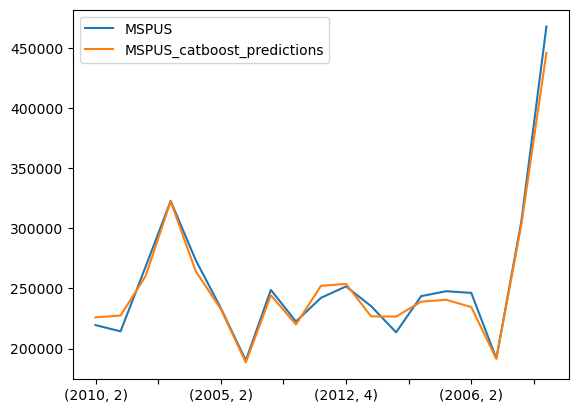

In [13]:
housing_predictions_df[['MSPUS', 'MSPUS_catboost_predictions']].plot()

# What happened to the timeseries (year, quarter) index!!!?

In [14]:
X_test.head(20)

,,CPIAUCSL,HOUST,CSUSHPINSA,HPIPONM226S,ETOTALUSQ176N,USSTHPI,WPUSI012011,ILSTHPI,MORTGAGE30US,MORTGAGE15US,MSACSR
2010,2,217.297333,602.000000,146.716333,187.843333,131749.0,323.22,197.533333,313.17,4.922308,4.300000,7.933333
2009,3,215.344000,588.333333,150.347667,190.290000,131375.0,332.66,188.333333,325.36,5.162308,4.606154,7.733333
2013,2,232.045000,868.000000,153.751333,194.726667,133408.0,321.52,209.666667,295.05,3.672308,2.840000,4.366667
2018,4,252.711000,1165.666667,205.056667,261.856667,138778.0,423.32,238.600000,340.14,4.784615,4.212308,7.066667
2013,4,234.162667,1009.000000,159.400333,199.686667,133799.0,328.75,209.633333,296.70,4.293077,3.345385,5.033333
2005,2,193.666667,2051.333333,169.519333,206.910000,125118.0,344.37,168.633333,342.58,5.708462,5.276154,4.266667
2002,4,181.500000,1729.666667,126.643000,165.666667,120350.0,276.38,144.633333,283.69,6.075385,5.470769,4.000000
2012,3,229.841000,780.333333,144.448667,184.286667,132890.0,312.68,206.100000,295.12,3.553846,2.837692,4.566667
2008,4,213.848667,663.000000,155.925667,194.570000,130797.0,348.18,198.733333,347.29,5.841429,5.557857,11.400000
2007,2,206.631000,1451.000000,181.851667,223.856667,128888.0,380.47,183.900000,371.47,6.358462,6.056154,7.800000
